# Data Gathering - By Foivos Gaitantzis

#### This section of the program is dedicated to downloading historical stock data (from Yahoo) and scraping news headlines from three different sources (Business Standard, The Financial Times & The New York Times) for a given datarange. 

### Load the Libraries

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import requests
import datetime
import time
import pandas as pd
import json
import yfinance as yf
from bs4 import BeautifulSoup
from lxml import etree

### Define the Query Parameters & Utility Functions

In [17]:
#Add Query Keywords to the List
query_list = ['aapl', 'apple+inc']

#Add Filter Keywords for Headlines
filter_keywords = ['aapl', 'iphone', 'ipad', 'apple', 'app', 'stock', 'aal', 'mac', 'steve']

#Set the Start Date
start_month = 1
start_day = 1
start_year = 2016

#Set the End Date
end_month = 12
end_day = 31
end_year = 2018

#---- New York Times API Parameters ----#

#NYTimes API Key
API_Key = "HIDDEN"

#NYTimes Date Interval Count (k)
Interval = 10

In [18]:
#Get the date range between two dates
def daterange(start, end):
    for i in range((end - start).days + 1):
        yield (start + datetime.timedelta(i))
        
#Get the date range between two dates for given intervals        
def daterangeintv(start, end, intv):
    for i in range(intv):
        yield (start + (end - start) / intv * i)
    yield end
        
#Define the two dates in datetime format
start_date = datetime.date(year = start_year, month = start_month, day = start_day)
end_date = datetime.date(year = end_year, month = end_month, day = end_day)

#Define the Requests Headers
Headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

### Download Historical Stock Data

In [19]:
# Get the data for the stock AAPL
Stock_Data = yf.download('AAPL', start_date, end_date)
Stock_Data = Stock_Data[['Close', 'Volume', 'Adj Close']]

#Extract the dataframe to a CSV file
Stock_Data.to_csv('files/'+query_list[0]+'_Stock_Data.csv')

#Display the first 5 rows of the Historical Stock Data
Stock_Data.head()

[*********************100%***********************]  1 of 1 completed


,Close,Volume,Adj Close
Date,,,
2016-01-04,105.349998,67649400,98.213585
2016-01-05,102.709999,55791000,95.752419
2016-01-06,100.699997,68457400,93.878586
2016-01-07,96.449997,81094400,89.916473
2016-01-08,96.959999,70798000,90.391907


### Business Standard News Scraping

In [20]:
#Prepare the Pandas Dataframe that will host the Business Standard News
PD_Headers = pd.DataFrame({'Date': [], 'Headline': []})

#Loop through each Date (day-to-day)
for Date in daterange(start_date, end_date):
    #Loop through each query on the query list
    for query in query_list:
    
        #Define the Business Standard Scraping URL
        URL = 'https://www.business-standard.com/advance-search?type=news&c-q=q&q='+query+'&c-range=range&range=bwn_dates&from_date='+Date.strftime("%d-%m-20%y")+'&to_date='+Date.strftime("%d-%m-20%y")

        #Request the URL and Retrieve the Headlines
        raw_html = requests.get(URL, headers=Headers)
        soup = BeautifulSoup(raw_html.text, 'lxml')
        raw = soup.find("ul", class_="listing")
        headline_list = raw.find_all("a", href=re.compile("/article/"))

        #Define the Date & Headline Lists
        dates = []
        headlines = []

        #Loop through each element in the headline list (for that specific query)
        for elem in headline_list:
            headlines.append(elem.text)
                
        #Loop through each element in the headline list (for that specific query)
        for elem in headline_list:
            dates.append(Date)

        #Create a new Dataframe that stores the data of this specific query
        News = pd.DataFrame({'Date': dates, 'Headline': headlines})
        
        #Concatanate this dataframe with the one containing ALL Business Standard Headlines
        PD_Headers = pd.concat([PD_Headers, News])
    
#Remove any possible duplicates
PD_Headers.drop_duplicates(['Headline'], keep='last')

#Filter the Keywords
PD_Headers = PD_Headers[PD_Headers['Headline'].str.contains('|'.join(filter_keywords), case=False)]

#Extract the dataframe to a CSV file
PD_Headers.to_csv('files/'+query_list[0]+'_News_BS.csv')

### New York Times News Scraping

In [21]:
#Create a list of dates using Intervals between start date and end date
Datelist = list(daterangeintv(start_date, end_date, Interval))

#Prepare the Pandas Dataframe that will host the New York Times News
PD_Headers = pd.DataFrame({'Date': [], 'Headline': []})

#Utility Function to access API
def access_api(query, page, start_date, end_date):
    
    #CPU sleep for 1s
    time.sleep(1)
    
    #Define the NYTimes Scraping URL
    URL = 'http://api.nytimes.com/svc/search/v2/articlesearch.json?q='+query+'&sort=relevance&fq='+query+'&page='+str(page)+'&api-key='+API_Key+'&begin_date='+start_date.strftime("%Y%m%d")+'&end_date='+end_date.strftime("%Y%m%d")
    
    raw_html = None
    content = None
    i = 0
    
    #Attempt to Request page 3 times without getting any errors.
    while i<3 and (content is None or raw_html.status_code!=200):
        try:
            raw_html = requests.get(URL)
            data = json.loads(raw_html.content.decode("utf-8"))
            content = data["response"]
        except ValueError:
            raise ValueError
        except KeyError:
            continue
        i += 1
    
    #Return the page content
    return content

#Loop through each Date Interval
for i in range(1, Interval):
    #Loop through each query on the query list
    for query in query_list:
        
        #Define the Date & Headline Lists
        dates = []
        headlines = []
        page = 0
        
        #Fetch content from API and store in the lists
        Data = access_api(query, page, Datelist[i-1], Datelist[i])
        while Data["meta"]["hits"] > 1000:
            Data = access_api(query, page, Datelist[i-1], Datelist[i])
        while page * 10 < Data["meta"]["hits"] and (page + 1) < 100:
            Data = access_api(query, page, Datelist[i-1], Datelist[i])
            for doc in Data["docs"]:
                headlines.append(doc['headline']['main'])
                dates.append(doc['pub_date'][0:10])
            page += 1
        
        #Create a new Dataframe that stores the data of this specific query
        News = pd.DataFrame({'Date': dates, 'Headline': headlines})
            
        #Concatanate this dataframe with the one containing ALL NYTimes News
        PD_Headers = pd.concat([PD_Headers, News])
        
#Remove any possible duplicates
PD_Headers.drop_duplicates(['Headline'], keep='last')

#Filter the Keywords
PD_Headers = PD_Headers[PD_Headers['Headline'].str.contains('|'.join(filter_keywords), case=False)]

#Extract the dataframe to a CSV file
PD_Headers.to_csv('files/'+query_list[0]+'_News_NYTimes.csv')   

### Financial Times News Scraping

In [22]:
#Prepare the Pandas Dataframe that will host the Financial Times News
PD_Headers = pd.DataFrame({'Date': [], 'Headline': []})

#Loop through each Date (day-to-day)
for Date in daterange(start_date, end_date):
    #Loop through each query on the query list
    for query in query_list:
        #Loop through the first 3 pages
        for page in range(1, 3):
    
            #Define the Google News Scraping URL
            URL = 'https://www.ft.com/search?expandRefinements=true&q='+query+'&concept=a39a4558-f562-4dca-8774-000246e6eebe&dateFrom='+Date.strftime("20%y-%m-%d")+'&dateTo='+Date.strftime("20%y-%m-%d")+'&page='+str(page)

            #Request the URL and Retrieve the Headlines
            raw_html = requests.get(URL, headers=Headers)
            soup = BeautifulSoup(raw_html.text, 'html.parser')
            headline_list = soup.find_all("div", {"class": "o-teaser__heading"})

            #Define the Date & Headline Lists
            dates = []
            headlines = []

            #Loop through each element in the headline list (for that specific query)
            for elem in headline_list:
                titles = elem.findAll(text=True)
                titles_string = ''.join(titles)
                headlines.append(titles_string)   
                
            #Loop through each element in the headline list (for that specific query)
            for elem in headline_list:
                dates.append(Date)

            #Create a new Dataframe that stores the data of this specific query
            News = pd.DataFrame({'Date': dates, 'Headline': headlines})
            
            #Concatanate this dataframe with the one containing ALL Financial Times News
            PD_Headers = pd.concat([PD_Headers, News])
    
#Remove any possible duplicates
PD_Headers.drop_duplicates(['Headline'], keep='last')

#Filter the Keywords
PD_Headers = PD_Headers[PD_Headers['Headline'].str.contains('|'.join(filter_keywords), case=False)]

#Extract the dataframe to a CSV file
PD_Headers.to_csv('files/'+query_list[0]+'_News_FT.csv')

### Combining ALL News Files into ONE

In [23]:
#Load all News sources
BS_data = pd.read_csv('files/'+query_list[0]+'_News_BS.csv')
FT_data = pd.read_csv('files/'+query_list[0]+'_News_FT.csv')
NYTimes_data = pd.read_csv('files/'+query_list[0]+'_News_NYTimes.csv')

#Set the Data Source to BS
BS_data = BS_data.assign(Source='BS')
BS_data = BS_data[['Date', 'Headline', 'Source']]

#Set the Data Source to FT
FT_data = FT_data.assign(Source='FT')
FT_data = FT_data[['Date', 'Headline', 'Source']]

#Set the Data Source to NYTimes
NYTimes_data = NYTimes_data.assign(Source='NYTimes')
NYTimes_data = NYTimes_data[['Date', 'Headline', 'Source']]

#Concatenate all data together
all_data = pd.concat([FT_data, NYTimes_data, BS_data])

all_data.loc[:, 'Date'] = pd.to_datetime(all_data['Date'], format='%m/%d/%Y')

#Remove any possible duplicates
all_data.drop_duplicates(['Headline'], keep='last')

#Extract the dataframe to a CSV file
all_data.to_csv('files/'+query_list[0]+'_News_All.csv')

### Histogram showing Headlines per Source

Text(0, 0.5, 'Frequency')

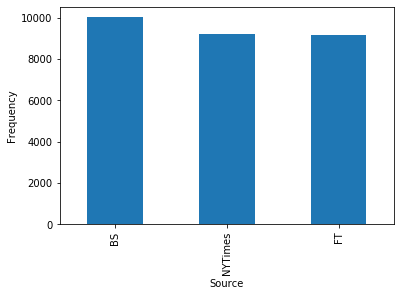

In [24]:
AX = all_data['Source'].value_counts().plot(kind='bar')
AX.set_xlabel('Source')
AX.set_ylabel('Frequency')